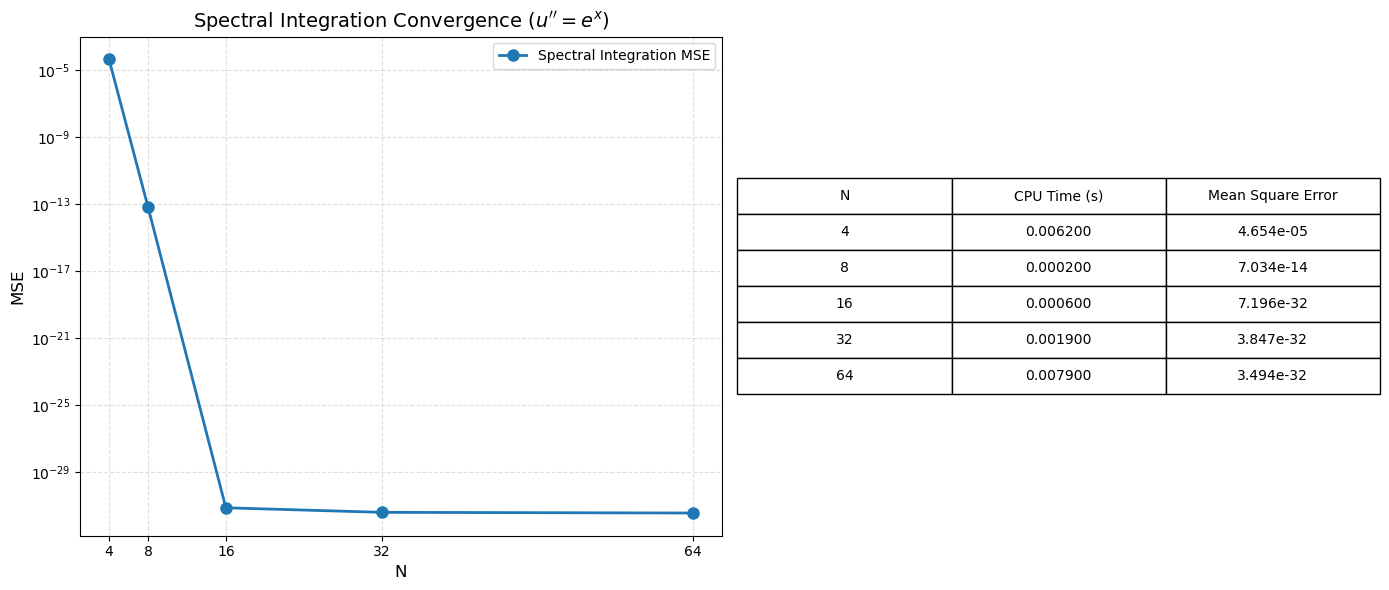

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ---------------------------------------------------------
# 1. 核心演算法
# ---------------------------------------------------------

def cheb_nodes(N):
    return np.cos(np.pi * np.arange(N + 1) / N)

def cheb_coeffs_pure_numpy(vals):
    N = len(vals) - 1
    coeffs = np.zeros(N + 1)
    for k in range(N + 1):
        sum_val = 0.0
        for j in range(N + 1):
            weight = 1.0
            if j == 0 or j == N: weight = 0.5
            term = weight * vals[j] * np.cos(k * j * np.pi / N)
            sum_val += term
        coeffs[k] = (2.0 / N) * sum_val
    coeffs[0] /= 2.0
    return coeffs

def spectral_integrate(coeffs):
    N = len(coeffs) - 1
    int_coeffs = np.zeros(N + 1)
    a_pad = np.append(coeffs, [0, 0])
    
    a_pad[0] *= 2.0 
    
    for k in range(1, N): 
        int_coeffs[k] = (1.0 / (2.0 * k)) * (a_pad[k-1] - a_pad[k+1])
    return int_coeffs

def solve_poisson_exp_x(N):
    start_time = time.perf_counter()
    x = cheb_nodes(N)
    f = np.exp(x) 
    
    sigma_coeffs = cheb_coeffs_pure_numpy(f)
    u_prime_coeffs = spectral_integrate(sigma_coeffs)
    u_coeffs = spectral_integrate(u_prime_coeffs)
    
    val_at_1 = np.sum(u_coeffs)
    val_at_neg1 = np.sum(u_coeffs * ((-1)**np.arange(N+1)))
    
    C0 = -0.5 * (val_at_1 + val_at_neg1)
    C1 = -0.5 * (val_at_1 - val_at_neg1)
    
    u_coeffs[0] += C0
    u_coeffs[1] += C1
    
    u_computed = np.polynomial.chebyshev.chebval(x, u_coeffs)
    end_time = time.perf_counter()
    return x, u_computed, end_time - start_time

# ---------------------------------------------------------
# 2. 執行與繪圖
# ---------------------------------------------------------
N_values = [4, 8, 16, 32, 64] 
mse_results = []
time_results = []

for N in N_values:
    x_nodes, u_comp, time_sec = solve_poisson_exp_x(N)
    u_exact = np.exp(x_nodes) - (np.exp(1)-np.exp(-1))/2 * x_nodes - (np.exp(1)+np.exp(-1))/2
    mse = np.mean((u_comp - u_exact)**2)
    mse_results.append(mse)
    time_results.append(time_sec)

# 繪圖部分
fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.semilogy(N_values, mse_results, 'o-', linewidth=2, markersize=8, label='Spectral Integration MSE')
ax1.set_title("Spectral Integration Convergence ($u''=e^x$)", fontsize=14)
ax1.set_xlabel("N", fontsize=12)
ax1.set_ylabel("MSE", fontsize=12)
ax1.grid(True, which="both", ls="--", alpha=0.4)
ax1.set_xticks(N_values)
ax1.legend()

# 表格部分
ax2 = fig.add_subplot(1, 2, 2)
ax2.axis('off')
table_data = [[N, f"{t:.6f}", f"{m:.3e}"] for N, t, m in zip(N_values, time_results, mse_results)]
col_labels = ["N", "CPU Time (s)", "Mean Square Error"]
the_table = ax2.table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
the_table.scale(1, 2)
the_table.set_fontsize(14)

plt.tight_layout()
plt.show()